# Output 문장 구조 EDA

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from transformers import AutoTokenizer

In [2]:
def make_dataframe(path: str) -> pd.DataFrame:
    """
    Read a json file and return a pandas DataFrame.

    Parameters:
    path (str): Path to the json file.

    Returns:
    pd.DataFrame: DataFrame of the json file.
    """
    # Read the json file
    with open(path, 'r') as file:
        data = json.load(file)

    # Create a DataFrame
    # columns = ['id', 'conversation', 'subject_keyword', 'output']
    df = pd.DataFrame(data)
    df['conversation'] = df['input'].apply(lambda x: x['conversation'])
    df['subject_keyword'] = df['input'].apply(lambda x: x['subject_keyword'])

    # Drop the 'input' column
    df.drop('input', axis=1, inplace=True)

    # Speakers in the conversation
    df['speakers'] = df['conversation'].apply(lambda turns: list(set(turn['speaker'] for turn in turns)))

    # Reorder the columns
    df = df[['id', 'conversation', 'subject_keyword', 'speakers', 'output']]

    return df

In [3]:
train_df = make_dataframe('../resource/data/일상대화요약_train.json')
dev_df = make_dataframe('../resource/data/일상대화요약_dev.json')
test_df = make_dataframe('../resource/data/일상대화요약_test.json')

In [3]:
result_df = make_dataframe('../results/result.json')

## output의 구문 구조의 정성적 평가 결과에 따른 정량적 평가


### 정성적 평가 결과output은 총 3가지 구조로 이루어져 있음

- 맨 처음에 **전반적인 요약** 이 나오고
- 두 번째로 **speaker 1**이 한 말에 대한 요약이 나오고
- 세 번째로 **speaker 2**가 한 말에 대한 요약으로 마무리된다

<br/>

- 실제로 모든 데이터가 위와 같은 구조로 이루어져 있는지를 통계로 확인


    - **문장 안에 speaker1과 speaker2가 모두 존재하는지 확인**

        - 모두 존재함!

    <br/>

    - **문장 안에 맨 첫 번째 문장인 전반적인 요약에 speaker가 등장하는 샘플들의 개수 확인**

        - train의 경우 87 / 506, dev의 경우 6 / 102

    <br/> 

    - **그 순서가 speaker1, speaker2 순서로 이루어져 있는지 확인**

        - 모두 그렇지는 않음! 
        - train dataset의 경우 506개 중에 328개
            
    <br/>
            
    - **그렇다면, conversation의 시작하는 speaker가 맨 앞에 오고, 그 다음 speaker가 뒤에 오는 순서인가?**

        - 위의 sample과 이어지는 다음 sample인 경우 speaker2가 먼저 conversation을 시작하기도 함
        - train dataset의 경우 492 / 506, dev dataset의 경우 100 / 102
            

### 결론
- 일단 conversation을 시작하는 speaker가 첫번째로 요약되고, 그 이후 그 다음 speaker가 요약되는 경우가 압도적으로 많았다

    - train의 경우 492/506, dev의 경우 100/102
    - 이를 구문 구조의 output이 나오도록 강제시켜주는 것이 일반화에 도움을 줄 수 있어보인다
    - rouge-1 평가지표에서는 앞 뒤의 순서가 바뀐다고 해도 점수에 변화가 없으므로 순서를 강제해주는 것이 평가지표 점수에 해를 끼치지 않을 것이다

<br/>

- output의 맨 첫 번째 문장에 speaker가 포함되는 경우가 10% 정도 있음

In [4]:
def output_semantic_structure_statistics(df: pd.DataFrame) -> None:
    """
    Print the statistics of the semantic structure of the output.

    Parameters:
    df (pd.DataFrame): DataFrame of the data.
    """
    # Copy the DataFrame
    df = deepcopy(df)


    # Check the speakers in the output
    speakers_in_output = df.apply(lambda row: not ((row['speakers'][0]) in row['output'] and (row['speakers'][1] in row['output'])), axis=1)
    print('The number of samples that Speakers are not in the output:', speakers_in_output.sum(), end='\n'+'-'*95+'\n')


    # Split outputs into sentences by '.'
    df['output'] = df['output'].apply(lambda x: x.split('.'))


    # Check the speakers in the total summarization sentence (==output[0])
    speakers_in_output = df.apply(lambda row: (row['speakers'][0]) in row['output'][0] or (row['speakers'][1] in row['output'][0]), axis=1)
    print('The number of samples that Speakers are in the total summarization sentence:', speakers_in_output.sum(), '/', len(df), end='\n'+'-'*95+'\n')


    # join the sentences without a first sentence
    df['output'] = df['output'].apply(lambda x: ' '.join(x[1:]))


    # sort the speakers name
    df['speakers'] = df['speakers'].apply(lambda x: sorted(x))


    # Check the first indexes of the two speakers and the speaker1 - speaker2 order in the output 
    correct_order_sample = df.apply(lambda row: row['output'].find(row['speakers'][0]) < row['output'].find(row['speakers'][1]), axis=1)
    print('The number of samples that the order of the speakers is (speaker1 - speaker2) :', correct_order_sample.sum(), '/', len(df), end='\n'+'-'*95+'\n')


    # check the starter speaker of the conversation is the first speaker in the output
    def compare_starter_speaker_is_first_speaker(row):
        starter_speaker = row['conversation'][0]['speaker']
        output = row['output']
        if row['output'].find(row['speakers'][0]) < row['output'].find(row['speakers'][1]):
            # When the order of the speakers is (speaker1 - speaker2)
            return True
        else:
            # When the order of the speakers is (speaker2 - speaker1)
            # Check the starter speaker is the second speaker
            # If the starter speaker is the second speaker, return True else False
            if starter_speaker == row['speakers'][1]:
                return True
            else:
                return False

    starter_speaker_is_first_speaker = df.apply(compare_starter_speaker_is_first_speaker, axis=1)
    print('The number of samples that the starter speaker is the first speaker in the output:', starter_speaker_is_first_speaker.sum(), '/', len(df), end='\n'+'-'*95+'\n')

    # Sample indexes that The starter speaker is not the first speaker in the output
    print('Sample indexes that The starter speaker is not the first speaker in the output:',
          df[~starter_speaker_is_first_speaker].index.tolist())

In [44]:
output_semantic_structure_statistics(train_df)

The number of samples that Speakers are not in the output: 0
-----------------------------------------------------------------------------------------------
The number of samples that Speakers are in the total summarization sentence: 87 / 506
-----------------------------------------------------------------------------------------------
The number of samples that the order of the speakers is (speaker1 - speaker2) : 328 / 506
-----------------------------------------------------------------------------------------------
The number of samples that the starter speaker is the first speaker in the output: 492 / 506
-----------------------------------------------------------------------------------------------
Sample indexes that The starter speaker is not the first speaker in the output: [31, 32, 33, 62, 96, 110, 141, 304, 305, 323, 328, 335, 336, 475]


In [45]:
output_semantic_structure_statistics(dev_df)

The number of samples that Speakers are not in the output: 0
-----------------------------------------------------------------------------------------------
The number of samples that Speakers are in the total summarization sentence: 6 / 102
-----------------------------------------------------------------------------------------------
The number of samples that the order of the speakers is (speaker1 - speaker2) : 73 / 102
-----------------------------------------------------------------------------------------------
The number of samples that the starter speaker is the first speaker in the output: 100 / 102
-----------------------------------------------------------------------------------------------
Sample indexes that The starter speaker is not the first speaker in the output: [81, 83]


In [49]:
output_semantic_structure_statistics(result_df)

The number of samples that Speakers are not in the output: 47
-----------------------------------------------------------------------------------------------
The number of samples that Speakers are in the total summarization sentence: 295 / 408
-----------------------------------------------------------------------------------------------
The number of samples that the order of the speakers is (speaker1 - speaker2) : 154 / 408
-----------------------------------------------------------------------------------------------
The number of samples that the starter speaker is the first speaker in the output: 203 / 408
-----------------------------------------------------------------------------------------------
Sample indexes that The starter speaker is not the first speaker in the output: [0, 1, 4, 5, 7, 8, 14, 17, 19, 20, 21, 22, 23, 24, 27, 30, 33, 34, 36, 37, 44, 46, 47, 50, 54, 55, 57, 58, 59, 60, 61, 62, 63, 65, 67, 68, 69, 73, 80, 83, 85, 86, 88, 89, 91, 92, 93, 95, 97, 98, 99, 101, 

- baseline에 추가 fine-tuning된 모델의 결과를 파악해보니
    - output안에 두 명의 speaker 모두가 들어있어야 하지만, 들어있지 않은 것이 47개나 되는 것을 볼 수 있고
    - total_summarization sentence에 원래는 speaker가 10%의 비율로 들어있지만 지금의 경우 3/4에 달하는 비율로 들어있다
    - 이는 모델의 output 구조를 강제시켜 줌으로써 보완할 수 있는 것 처럼 보인다
        - few-shot을 통해 이상적인 output의 예시를 보여주자
        - prompt 안에 해당 구조로 작성해달라고 추가하자.

In [5]:
output_semantic_structure_statistics(result_df)

The number of samples that Speakers are not in the output: 103
-----------------------------------------------------------------------------------------------
The number of samples that Speakers are in the total summarization sentence: 378 / 408
-----------------------------------------------------------------------------------------------
The number of samples that the order of the speakers is (speaker1 - speaker2) : 150 / 408
-----------------------------------------------------------------------------------------------
The number of samples that the starter speaker is the first speaker in the output: 215 / 408
-----------------------------------------------------------------------------------------------
Sample indexes that The starter speaker is not the first speaker in the output: [0, 1, 2, 5, 7, 8, 10, 11, 12, 14, 18, 19, 20, 21, 22, 23, 27, 29, 32, 35, 37, 41, 46, 47, 49, 55, 57, 58, 60, 61, 62, 64, 65, 66, 68, 69, 70, 73, 78, 79, 80, 85, 86, 87, 89, 91, 93, 94, 96, 98, 99, 102,

<br/>

### speaker1의 요약 내용과, spekaer2의 요약 내용의 길이를 각각 확인 
    
- 각 인물의 발화 내용 길이와 요약 내용의 길이 간의 상관관계 파악
    - 만약 길이에 따라 늘어난다면, 실제 학습된 모델도 그러하는지 파악
        - 그러하다
        
    - 만약 길이가 항상 고정된다면, 그에 따른 prompt 추가 및 추가 아이디어 생각 -> 잘 변화되는 것을 확인했기에 추가 실험 중단

In [6]:
def correlation_between_utterance_length_and_output_length(df: pd.DataFrame, tokenizer) -> None:
    """
    Plot the correlation between the utterance length and the output length.

    Parameters:
    df (pd.DataFrame): DataFrame of the data.
    tokenizer: Tokenizer from Hugging Face Transformers.
    """
    # Copy the DataFrame
    df = deepcopy(df)

    # Calculate the length of the utterance and the output
    total_utterance_length = df['conversation'].apply(lambda x: sum(len(tokenizer.encode(turn['utterance'], add_special_tokens=False)) for turn in x))
    output_length = df['output'].apply(lambda x: len(tokenizer.encode(x)))

    # Plot the correlation
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=total_utterance_length, y=output_length)
    plt.xlabel('Total Utterance Length')
    plt.ylabel('Output Length')
    plt.title('Correlation between Utterance Length and Output Length')
    plt.show()

In [8]:
tokenizer = AutoTokenizer.from_pretrained('MLP-KTLim/llama-3-Korean-Bllossom-8B')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


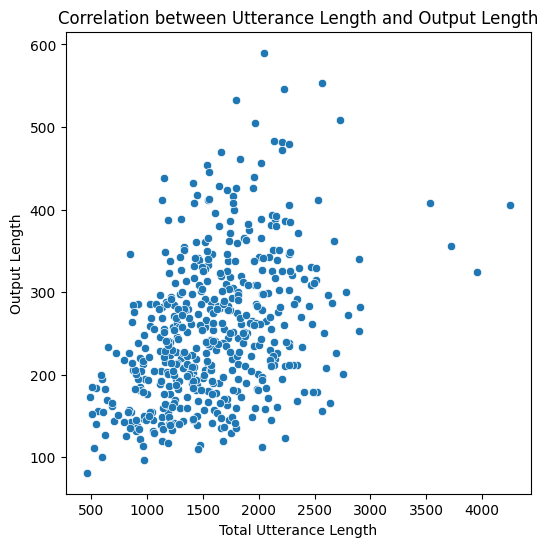

In [16]:
tokenizer = AutoTokenizer.from_pretrained('MLP-KTLim/llama-3-Korean-Bllossom-8B')
correlation_between_utterance_length_and_output_length(train_df, tokenizer)

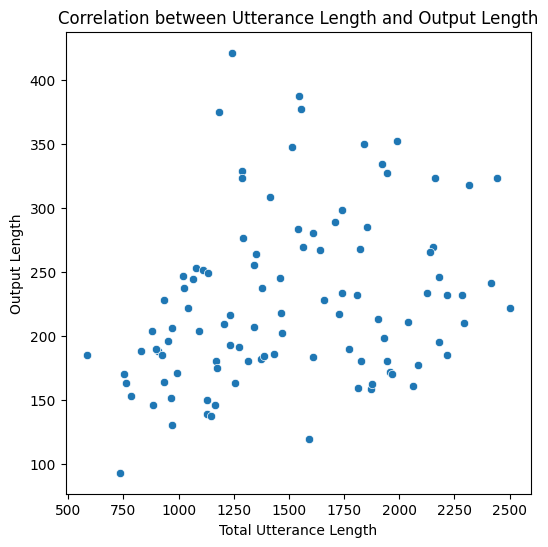

In [46]:
correlation_between_utterance_length_and_output_length(dev_df, tokenizer)

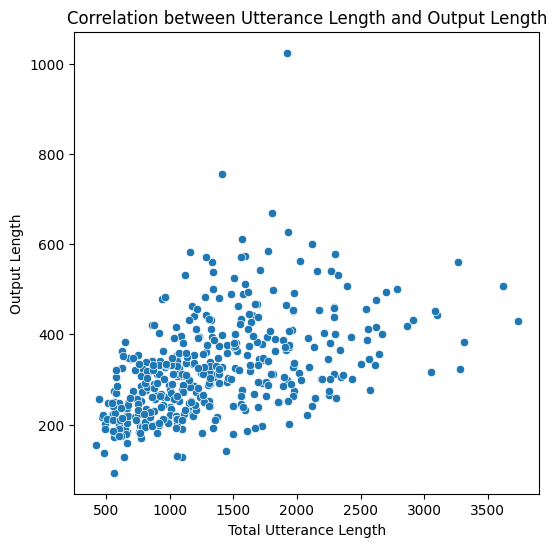

In [50]:
correlation_between_utterance_length_and_output_length(result_df, tokenizer)

<br/>

<br/>

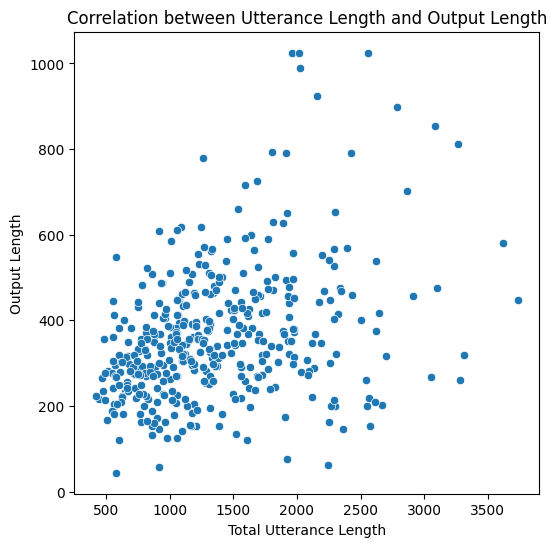

In [9]:
correlation_between_utterance_length_and_output_length(result_df, tokenizer)

## output 내의 개행문자, 특수 문자 존재 여부 확인

In [10]:
def special_character_statistics(df: pd.DataFrame) -> None:
    """
    Print the statistics of the punctuation in the output.

    Parameters:
    df (pd.DataFrame): DataFrame of the data.
    """
    # Copy the DataFrame
    df = deepcopy(df)

    # Check the sp_token in the output
    sp_token = ['\n', '!', '?', '#', '@', '$', '%', '^', '&', '*', '(', ')', '-', '_', '+', '=', '[', ']', '{', '}', '|', '\\', ';', ':', '"', "'", '<', '>', ',', '.', '/', ' ']
    for punc in sp_token:
        df['punctuation'] = df['output'].apply(lambda x: punc in x)
        punc = punc if punc != '\n' else '\\n'
        if df['punctuation'].sum():
            print(f'The number of samples that have the special token in the output "{punc}":', df['punctuation'].sum(), '/', len(df), end='\n'+'-'*95+'\n')

In [108]:
special_character_statistics(train_df)

The number of samples that have the special token in the output "\n": 2 / 506
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output "-": 5 / 506
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output ",": 382 / 506
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output ".": 506 / 506
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output " ": 506 / 506
-----------------------------------------------------------------------------------------------


In [109]:
special_character_statistics(dev_df)

The number of samples that have the special token in the output "-": 2 / 102
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output ",": 75 / 102
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output ".": 102 / 102
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output " ": 102 / 102
-----------------------------------------------------------------------------------------------


In [110]:
special_character_statistics(result_df)

The number of samples that have the special token in the output "\n": 301 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output "?": 1 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output "#": 9 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output "%": 2 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output "&": 4 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output "*": 58 / 408
------------------------------------------------------

In [11]:
special_character_statistics(result_df)

The number of samples that have the special token in the output "\n": 330 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output "?": 6 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output "%": 2 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output "&": 4 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output "(": 1 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output ")": 1 / 408
-------------------------------------------------------

In [17]:
# after post-processing
result_df = make_dataframe('../result.json')

special_character_statistics(result_df)

The number of samples that have the special token in the output "-": 4 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output ",": 403 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output ".": 408 / 408
-----------------------------------------------------------------------------------------------
The number of samples that have the special token in the output " ": 408 / 408
-----------------------------------------------------------------------------------------------


- 결과, 필요없는 특수문제를 제거해 주는 것이, 점수 향상에 큰 도움을 줄 것으로 보임
    
    - 이걸 prompt를 통해 모델에 제안을 해줄 것일지, 아님 후처리를 통해 없엘 것인지를 선택해야함

    <br/>
    
    - prompt를 통해 제안을 한다면
        
        - 보다 깔끔한 문장 형태로 특수문자가 제거될 것임
        - 하지만, prompt의 특성상 완벽하게 제거되지 않을 가능성이 존재

    - 후처리를 통해 제거한다면

        - 완벽하게 제거하는 것이 가능
        - 하지만, 문장이 이상해질 가능성이 있음. 해당 특수문자가 해당 문장 내에서 특별한 역할을 수행하는 경우가 존재하기 떄문

---

## Output 구조에 맞게 모델이 내뱉도록 하기 위해 할 수 있는 것들

- **prompt를 구성한다**
    - 예를 들어, "요약을 하는데 맨 첫 문장은 전반적인 대화에 대한 요약, 이어서 'speaker 1은 ~~' 형태의 여러개의 문장, 마지막으로 'speaker 2는 ~' 형태의 여러개의 문장으로 작성해줘'

</br>

- **대화 내역의 노이즈를 없앤 후 모델에 전달한다**
    - 대화 내역과 output 간의 상관관계를 파악하여 필요한 feature들과 불필요한 feautre들을 파악하고
    - 필요한 feature들만 남겨 모델의 입력으로 사용한다

</br>

- **최대 길이에 의해 짤리는 부분을 완전히 없앤다**
    - 모델이 맨 마지막 지시(instruction)에 해당하는 부분의 토큰까지 모두 입력으로 받아낼 수 있도록 
    - 최대 길이를 조절하던지, 앞선 방식으로 입력을 줄여서 사용한다

</br>

- **lost in the middle 문제가 발생하는지 파악하고 이를 해결한다**
    - 대화 내역이 워낙 길다 보니까, 중간에 해당하는 부분이 제대로 요약되고 있는지를 validation dataset에 대해 평가한다
    - 만약 제대로 요약되지 않고 있다면, 이를 해결하기 위해 
        - 앞서 분석한 요약에 별로 쓸모가 없는 문장들을 중간에 배치하고
        - 중요한 문장을 앞 뒤에 배치함으로써 해결한다

<br/>